In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Load Data
df = pd.read_excel("Updated_Party_Alliance_Data.xlsx")


In [4]:
# Fix Column Names
df = df.rename(columns=lambda x: x.strip())


In [5]:
# Drop Unnecessary Columns
X = df.drop(columns=['Party', 'Popular vote %', 'Seats Won'])
y = df[['Popular vote %', 'Seats Won']]

In [7]:
df.head()

,Party,PM Candidate,Alliance,Popular vote Votes,Popular vote %,Vote Share Change (%),Seats Contested,Seats Won,Seats Change,Campaign Expenditure (INR in Crores),Number of Rallies,Social media mention,Sentiment score
0,Bharatiya Janata Party,Narendra Modi,Part of NDA,235973935,36.932,0.428,441,240,63,5000,150,500000,0.70
1,Indian National Congress,Undeclared,Part of INDIA alliance,136759064,21.404,1.916,328,99,47,3000,140,450000,0.60
2,Samajwadi Party,Undeclared,Part of INDIA alliance,29549381,4.624,2.073,71,37,32,500,50,120000,0.50
3,All India Trinamool Congress,Mamata Banerjee,Part of INDIA alliance,28213393,4.415,0.350,48,29,7,800,60,150000,0.55
4,Dravida Munnetra Kazhagam,Undeclared,Part of INDIA alliance,11754710,1.839,0.424,22,22,2,600,45,100000,0.65


In [8]:
# Identify Feature Types
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()

# Data Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [9]:
# Train-Test Split (Ensuring consistency for both targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y1_train, y1_test = y_train['Popular vote %'], y_test['Popular vote %']
y2_train, y2_test = y_train['Seats Won'], y_test['Seats Won']

In [11]:
# Define parameter grids (without "model__" prefix)
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}

# Define Pipelines
model1_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(XGBRegressor(random_state=42), xgb_params, cv=3, scoring='r2', n_jobs=-1))
])

model2_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='r2', n_jobs=-1))
])

# Train Models
model1_pipeline.fit(X_train, y1_train)
model2_pipeline.fit(X_train, y2_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Popular vote Votes',
                                                   'Vote Share Change (%)',
                                                   'Seats Contested',
                                                   'Seats Change',
                                                   'Campaign Expenditure (INR '
                                                   'in Crores)',
                                                   'Number of Rallies',
                                                   'Social media mention',
                                                   'Sentiment score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PM Candidate',
                                                   'Alliance'])])),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=RandomForestRegressor(random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [None, 10],
                                          'n_estimators': [100, 200]},
                              scoring='r2'))])

In [12]:
# Predictions
y1_pred = model1_pipeline.predict(X_test)
y2_pred = model2_pipeline.predict(X_test)

In [13]:
# Model Evaluation
print("Vote Share Prediction:")
print("MAE:", mean_absolute_error(y1_test, y1_pred))
print("MSE:", mean_squared_error(y1_test, y1_pred))
print("R² Score:", r2_score(y1_test, y1_pred))

print("\nSeats Won Prediction:")
print("MAE:", mean_absolute_error(y2_test, y2_pred))
print("MSE:", mean_squared_error(y2_test, y2_pred))
print("R² Score:", r2_score(y2_test, y2_pred))


Vote Share Prediction:
MAE: 0.1671161306649446
MSE: 0.0634073452607891
R² Score: 0.8832625110745131

Seats Won Prediction:
MAE: 1.8949999999999998
MSE: 9.607916666666666
R² Score: -4.321307692307692


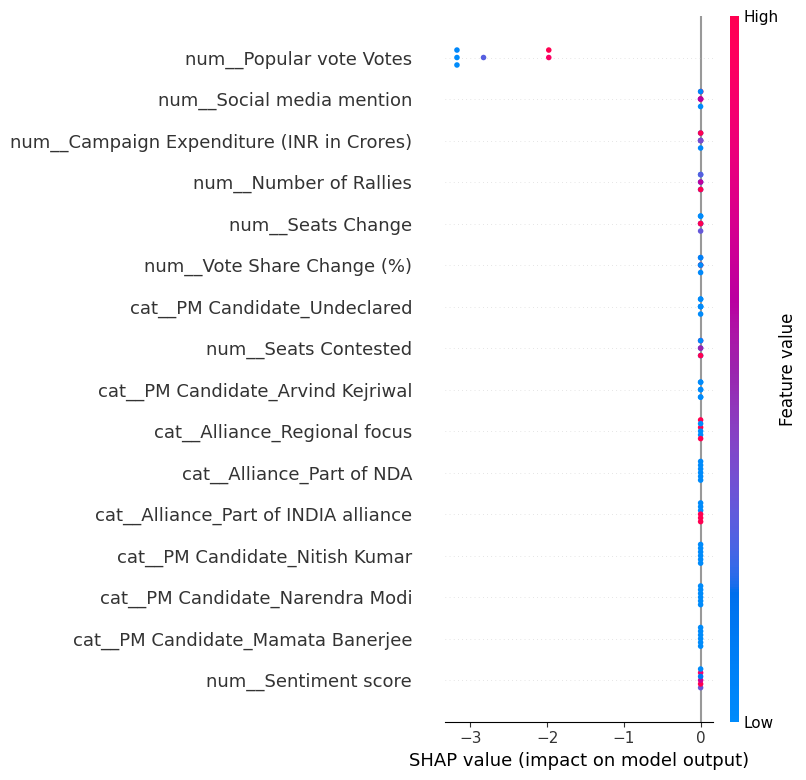

In [18]:
# Apply the same transformation as training data
X_test_transformed = model1_pipeline.named_steps['preprocessor'].transform(X_test)

# Ensure it's a DataFrame
X_test_transformed = pd.DataFrame(X_test_transformed, columns=model1_pipeline.named_steps['preprocessor'].get_feature_names_out())

# SHAP Explainer
import shap
explainer = shap.Explainer(model1_pipeline.named_steps['model'].best_estimator_)
shap_values = explainer(X_test_transformed)

# Summary plot
shap.summary_plot(shap_values, X_test_transformed)


C:\Users\arsha\AppData\Local\Temp\ipykernel_10064\470950436.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=predictions_summary, x='Party', y='Predicted Vote Share % (2029)', palette='viridis')


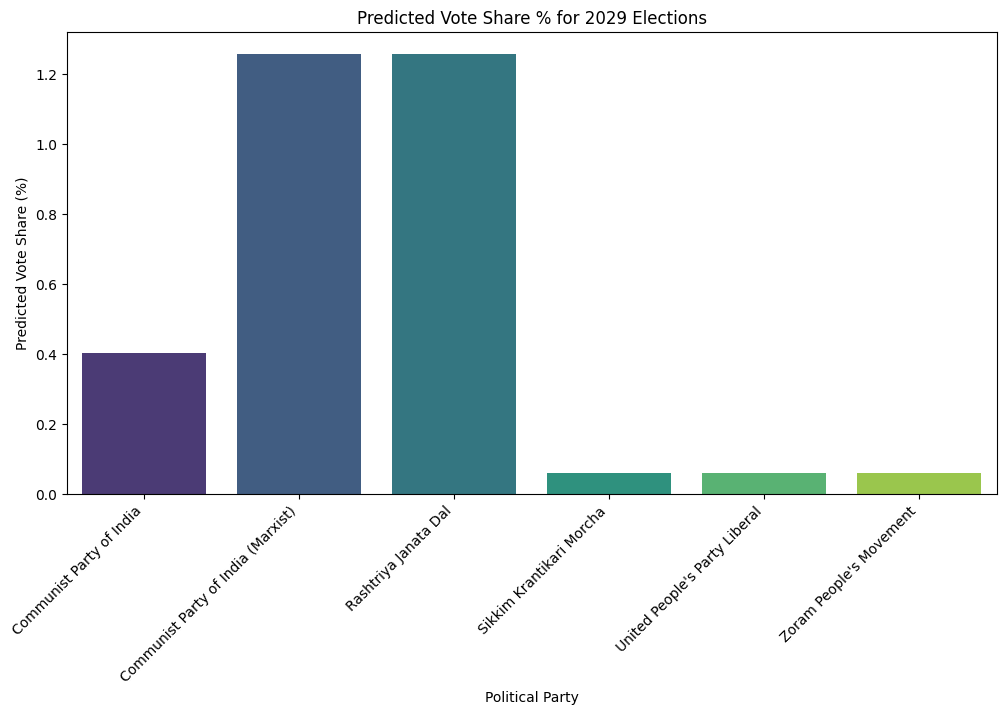

C:\Users\arsha\AppData\Local\Temp\ipykernel_10064\470950436.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=predictions_summary, x='Party', y='Predicted Seats Won (2029)', palette='coolwarm')


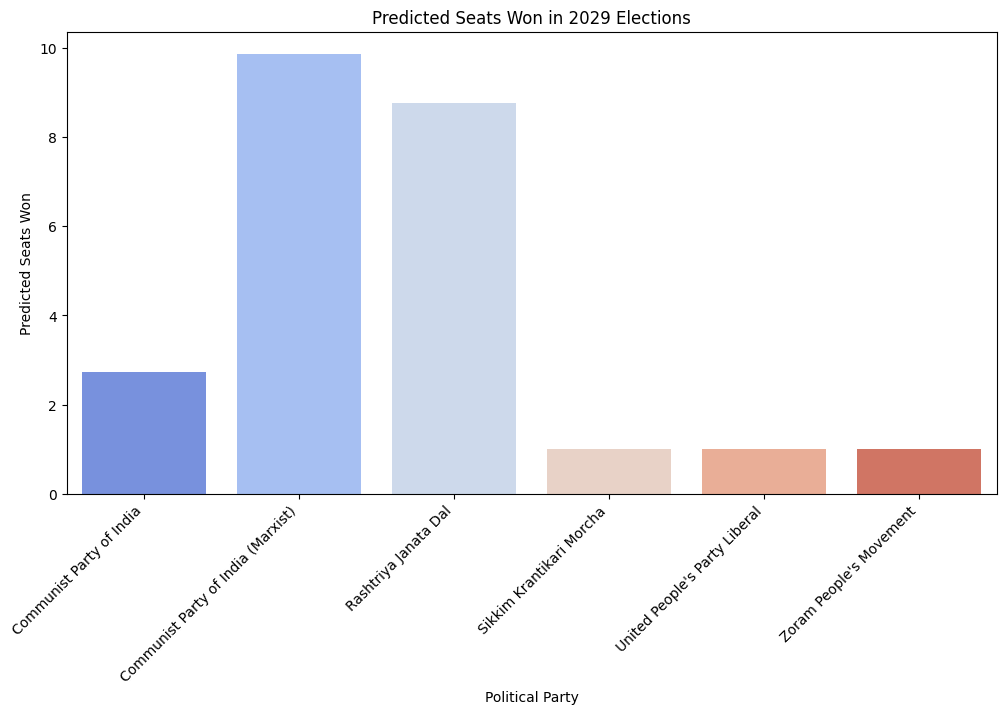

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get Party Names from Original Dataset
parties_2029 = df['Party'][y_test.index]  # Extract corresponding party names

# Create DataFrame for Predictions
predictions_df = pd.DataFrame({
    'Party': parties_2029.values,
    'Predicted Vote Share % (2029)': y1_pred,
    'Predicted Seats Won (2029)': y2_pred
})

# Group by Party to get total predicted vote share and seats won
predictions_summary = predictions_df.groupby('Party').sum().reset_index()

# 🔹 Plot Vote Share Predictions
plt.figure(figsize=(12, 6))
sns.barplot(data=predictions_summary, x='Party', y='Predicted Vote Share % (2029)', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted Vote Share % for 2029 Elections')
plt.xlabel('Political Party')
plt.ylabel('Predicted Vote Share (%)')
plt.show()

# 🔹 Plot Seats Won Predictions
plt.figure(figsize=(12, 6))
sns.barplot(data=predictions_summary, x='Party', y='Predicted Seats Won (2029)', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Predicted Seats Won in 2029 Elections')
plt.xlabel('Political Party')
plt.ylabel('Predicted Seats Won')
plt.show()
